In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from AlgoritmoGenetico.Operadores.calibrador import Calibrador
from sidermit.city import Graph
from sidermit.publictransportsystem import TransportMode, passenger

In [4]:
n, L, g,  P = 6, 10, 1.8, 1
Y = n*1000
tmode = TransportMode(name='bus', bya=0, co=8.61 , c1=0.15, c2=0, v=20, t=2.5, fmax=150, kmax=160, theta=0.5, tat=0, d=1, fini=12)
passenger_obj = passenger.Passenger(va=4, pv=2.74, pw=5.48, pa=0, pt=16, spv=2.74, spw=5.48, spa=0, spt=16)
graph_obj = Graph.build_from_parameters(n=n, l=L, g=g, p=P)

In [5]:
calibrador = Calibrador(n=n, graph_obj=graph_obj, tmode=tmode, passenger_obj=passenger_obj, Y=Y, L=L, build=False)

In [7]:
edl_completa = pd.read_csv('edl_completa.csv')
edl_dividida = pd.read_csv('edl_dividida.csv')

calibrador.set_edl_compelta(edl_completa)
calibrador.set_edl_dividida(edl_dividida)

In [42]:
edl_dividida[(edl_dividida['alpha'] == 0.4) & (edl_dividida['a'] == 0.5)]

,Unnamed: 0,CIR_I_bus,CIR_R_bus,F_bus_1,F_bus_2,F_bus_3,F_bus_4,F_bus_5,F_bus_6,DS3_bus_1,DS3_bus_2,DS3_bus_3,alpha,beta,a,VRC,factor_carga,transbordos,largo_lineas,EDL_id
89,89,13.739363,13.969238,10.349782,10.349774,10.349782,10.349785,10.349771,10.349771,14.207639,14.207648,14.207643,0.4,0.0,0.5,27303.001135,0.256410,2.815386,0.35,1
90,90,12.735762,12.926852,10.349974,10.349975,10.349991,10.349991,10.349984,10.349953,14.334116,14.334112,14.334118,0.4,0.1,0.5,26188.448070,0.266667,2.454646,0.35,1
91,91,11.610260,11.764006,10.350307,10.350305,10.350298,10.350298,10.350293,10.350317,14.529641,14.529646,14.529650,0.4,0.2,0.5,25041.972432,0.277778,2.064744,0.35,1
92,92,10.295500,10.411456,10.349419,10.349411,10.349415,10.349420,10.349409,10.349409,14.824764,14.824779,14.824774,0.4,0.3,0.5,23848.447924,0.289855,1.638185,0.35,1
93,93,8.660678,8.732952,10.349564,10.349565,10.349565,10.349565,10.349566,10.349558,15.265218,15.265219,15.265211,0.4,0.4,0.5,22580.206259,0.303030,1.164594,0.35,1
94,94,6.358542,6.389872,10.349594,10.349580,10.349604,10.349588,10.349582,10.349568,15.938254,15.938332,15.938213,0.4,0.5,0.5,21176.310139,0.317460,0.627421,0.35,1
216,216,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.4,0.6,0.5,NaN,NaN,NaN,NaN,1
217,217,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.4,0.7,0.5,NaN,NaN,NaN,NaN,1
218,218,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.4,0.8,0.5,NaN,NaN,NaN,NaN,1
219,219,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.4,0.9,0.5,NaN,NaN,NaN,NaN,1


In [9]:
# Agregamos una columna para identificarlas después de la unión
edl_completa['EDL_id'] = 0
edl_dividida['EDL_id'] = 1
# Unir ambas tablas
cols = ['a', 'alpha', 'beta', 'VRC', 'EDL_id']
data = pd.concat([edl_completa[cols], edl_dividida[cols]], axis=0)
# Eliminar los puntos infactibles
data = data[~data['VRC'].isna()]
data = data.reset_index(drop=True)
# Ordenar
data = data.sort_values(by=['a', 'alpha', 'beta'])
# Eliminamos los puntos donde alguna de las opt no terminó
aux = data.groupby(['a', 'alpha', 'beta']).VRC.transform('count') > 1
data = data[aux]
# Encontrar mínimo para cada a, alpha y beta.
data_min_index = data.groupby(['a', 'alpha', 'beta'])['VRC'].idxmin()
data_min = data.loc[data_min_index]
data_min.head()

,a,alpha,beta,VRC,EDL_id
0,0.3,0.0,0.0,24177.793877,0
1,0.3,0.0,0.1,23619.052766,0
2,0.3,0.0,0.2,23060.077591,0
3,0.3,0.0,0.3,22500.853868,0
4,0.3,0.0,0.4,21941.365772,0


In [15]:
def graficarPred(data, a):
    """
    Función para graficar un mapa de calor con la predicción de división en el SC.
    :param data: dataFrame. Información a graficar, debe tener las columnas ['alpha', 'beta', 'SC_division'].
    :return:
    """
    pivot = data[data['a'] == a].pivot(index='beta', columns='alpha', values='EDL_id')
    pivot = pivot.sort_index(ascending = False)

    colors = {'steelblue': 0, 'plum':1}
    l_colors = sorted(colors, key=colors.get)

    fig, ax = plt.subplots()
    sns.heatmap(pivot, annot=False, cmap=l_colors,  vmin=0, vmax=1, ax=ax)

    # Manually specify colorbar labelling after it's been generated
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks([0.25, 0.75])
    colorbar.set_ticklabels([r'$n_0$', r'$n_1$'])
    colorbar.ax.tick_params(labelsize=12)

    ax.set_title(f'EDL óptima predicción, a={a}')

    plt.show()

In [23]:
edl_dividida[(edl_dividida['a'] == 0.5) & (edl_dividida['alpha'] == 0.4)]

,Unnamed: 0,CIR_I_bus,CIR_R_bus,F_bus_1,F_bus_2,F_bus_3,F_bus_4,F_bus_5,F_bus_6,DS3_bus_1,DS3_bus_2,DS3_bus_3,alpha,beta,a,VRC,factor_carga,transbordos,largo_lineas,EDL_id
89,89,13.739363,13.969238,10.349782,10.349774,10.349782,10.349785,10.349771,10.349771,14.207639,14.207648,14.207643,0.4,0.0,0.5,27303.001135,0.256410,2.815386,0.35,1
90,90,12.735762,12.926852,10.349974,10.349975,10.349991,10.349991,10.349984,10.349953,14.334116,14.334112,14.334118,0.4,0.1,0.5,26188.448070,0.266667,2.454646,0.35,1
91,91,11.610260,11.764006,10.350307,10.350305,10.350298,10.350298,10.350293,10.350317,14.529641,14.529646,14.529650,0.4,0.2,0.5,25041.972432,0.277778,2.064744,0.35,1
92,92,10.295500,10.411456,10.349419,10.349411,10.349415,10.349420,10.349409,10.349409,14.824764,14.824779,14.824774,0.4,0.3,0.5,23848.447924,0.289855,1.638185,0.35,1
93,93,8.660678,8.732952,10.349564,10.349565,10.349565,10.349565,10.349566,10.349558,15.265218,15.265219,15.265211,0.4,0.4,0.5,22580.206259,0.303030,1.164594,0.35,1
94,94,6.358542,6.389872,10.349594,10.349580,10.349604,10.349588,10.349582,10.349568,15.938254,15.938332,15.938213,0.4,0.5,0.5,21176.310139,0.317460,0.627421,0.35,1
216,216,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.4,0.6,0.5,NaN,NaN,NaN,NaN,1
217,217,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.4,0.7,0.5,NaN,NaN,NaN,NaN,1
218,218,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.4,0.8,0.5,NaN,NaN,NaN,NaN,1
219,219,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.4,0.9,0.5,NaN,NaN,NaN,NaN,1


In [24]:
edl_completa[(edl_completa['a'] == 0.5) & (edl_completa['alpha'] == 0.4)]

,Unnamed: 0,D3_bus_1,D3_bus_2,D3_bus_3,CIR_I_bus,CIR_R_bus,alpha,beta,a,VRC,factor_carga,transbordos,largo_lineas,EDL_id
89,89,11.656040,11.656039,11.656046,11.429199,11.550178,0.4,0.0,0.5,26105.973950,0.218750,32.601119,3.867857,0
90,90,11.611598,11.611573,11.611625,10.752787,10.858083,0.4,0.1,0.5,25025.616991,0.203540,30.142275,3.867857,0
91,91,11.606045,11.606041,11.606043,9.957818,10.045542,0.4,0.2,0.5,23924.327274,0.193548,27.571843,3.867857,0
92,92,11.650832,11.650837,11.650832,8.980747,9.048666,0.4,0.3,0.5,22791.539935,0.191686,24.890922,3.867857,0
93,93,11.771643,11.771336,11.771872,7.692638,7.738048,0.4,0.4,0.5,21607.319488,0.202128,22.087025,3.867857,0
94,94,12.012632,12.012641,12.012619,5.761312,5.781948,0.4,0.5,0.5,20325.281311,0.230769,19.146514,3.867857,0
216,216,NaN,NaN,NaN,NaN,NaN,0.4,0.6,0.5,NaN,NaN,NaN,NaN,0
217,217,NaN,NaN,NaN,NaN,NaN,0.4,0.7,0.5,NaN,NaN,NaN,NaN,0
218,218,NaN,NaN,NaN,NaN,NaN,0.4,0.8,0.5,NaN,NaN,NaN,NaN,0
219,219,NaN,NaN,NaN,NaN,NaN,0.4,0.9,0.5,NaN,NaN,NaN,NaN,0


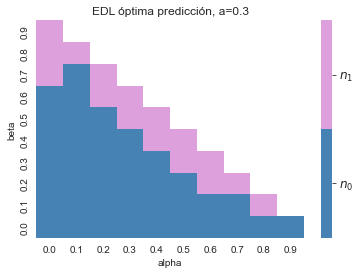

In [40]:
graficarPred(data_min, 0.3)

In [8]:
frontera = calibrador.obtener_frontera()
frontera.head()

,a,alpha,beta,EDL_id
6,0.3,0.0,0.6,0
172,0.3,0.0,0.7,1
16,0.3,0.1,0.6,0
17,0.3,0.1,0.7,0
183,0.3,0.1,0.8,1


In [5]:
terminos_optimos = calibrador.calibrar_frontera(frontera)
terminos_optimos

array([0.0226486 , 0.24418634, 0.72320651])

In [33]:
d1, d2, umbral = 0.2, 0.5, 0.54

completa = edl_completa.drop('EDL_id', axis=1)
pred = completa.merge(frontera[['a', 'alpha', 'beta', 'EDL_id']], on=['a', 'alpha', 'beta'], how='right')
pred['indice'] = pred['factor_carga']*(1-pred['transbordos']*d1)*(1+pred['largo_lineas']*d2)
pred['error'] = (pred['indice'] - umbral)*(1-2*pred['EDL_id'])
pred.loc[pred['error'] > 0, 'error'] = np.cbrt(pred[pred['error'] > 0]['error'])

In [34]:
pred.head()

,Unnamed: 0,D3_bus_1,D3_bus_2,D3_bus_3,CIR_I_bus,CIR_R_bus,alpha,beta,a,VRC,factor_carga,transbordos,largo_lineas,EDL_id,indice,error
0,6,7.482955,7.483033,7.482946,16.612917,16.965523,0.0,0.6,0.3,20821.525420,0.453333,3.207279,3.867857,0,0.476881,-0.063119
1,7,7.474519,7.474557,7.474580,16.233720,16.569506,0.0,0.7,0.3,20261.133110,0.473333,2.408171,3.867857,1,0.719868,-0.179868
2,16,8.736865,8.736865,8.736875,13.942279,14.180021,0.1,0.6,0.3,19743.961146,0.085366,5.493960,3.867857,0,-0.024743,-0.564743
3,17,9.118930,9.118932,9.118952,12.720320,12.911246,0.1,0.7,0.3,18991.383003,0.186257,4.605800,3.867857,0,0.043083,-0.496917
4,18,9.877411,9.877421,9.877413,10.544875,10.665299,0.1,0.8,0.3,18046.415319,0.342105,3.644678,3.867857,1,0.272071,0.644674


In [19]:
calibrador.error_prediccion(0.8, 0.2, 0.54, frontera)

0.0